# xres_EDSR || EPOCH Laboratory

Super-Resolution is a Generative Adversarial Network (GAN) that can generate super-resolution images from low-resolution images, with finer details and higher quality.

- Python: 3.7.9
- Tensorflow: 2.4.1

In [1]:
%pylab inline

import os, math, random, datetime

import tensorflow as tf

from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, BatchNormalization, Activation, LeakyReLU, Add, Dense, Flatten, Lambda
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

from IPython.display import clear_output

Populating the interactive namespace from numpy and matplotlib


In [2]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
print("Version:", tf.__version__)
print("Eager mode:", tf.executing_eagerly())
print("GPU is", "available" if physical_devices else "NOT AVAILABLE")

Version: 2.4.1
Eager mode: True
GPU is available


## Explore the data

In [4]:
OUTDIR = 'metrics'

In [5]:
ROOT_0 = '/mnt/vanguard/datasets/vimeo_90k/toflow'
ROOT_1 = '/mnt/vanguard/datasets/ffhq-dataset/ffhq-512'
ROOT_2 = '/mnt/vanguard/datasets/celeba_bundle/data_hq_1024'

In [6]:
dir_list = [ROOT_0]

In [7]:
def load(file):
    file = tf.io.read_file(file)
    image = tf.image.decode_png(file)
    data = tf.cast(image, tf.float32)
    
    return data

In [8]:
dataset = []

for ROOT in dir_list:
    print(ROOT)
    for path, subdirs, files in os.walk(ROOT):
        for name in sorted(files):
            filepath = os.path.join(path, name)
            dataset.append(filepath)
            
random.shuffle(dataset)

/mnt/vanguard/datasets/vimeo_90k/toflow


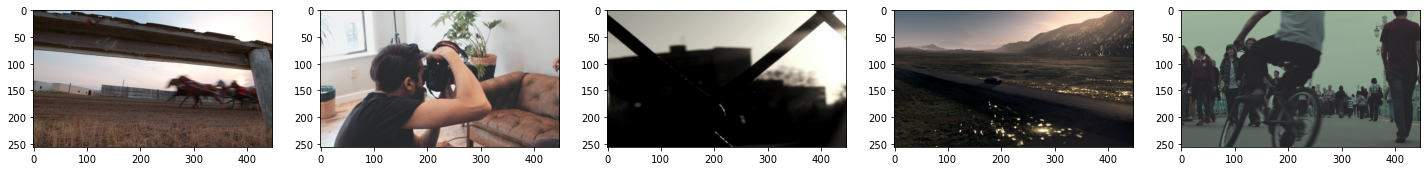

In [9]:
nplot = 5

fig = plt.figure(figsize=(30,30))
for count in range(1,nplot+1):
    file = random.choice(dataset)
    input_image = load(file)
    ax = fig.add_subplot(1,nplot+1,count)
    ax.imshow(input_image/255.0)

## Create the GAN

In [10]:
r = 4
depth = 32
num_filters = 256

image_shape = (256, 256, 3)
downsample_shape = (image_shape[0]//r, image_shape[1]//r, image_shape[2])

low_resolution_shape = downsample_shape
high_resolution_shape = image_shape

print("Low Resolution Shape =", low_resolution_shape)
print("High Resolution Shape =", high_resolution_shape)

Low Resolution Shape = (64, 64, 3)
High Resolution Shape = (256, 256, 3)


#### The Generator

In [11]:
def edsr_residual(x, num_filters, scaling):
    res = Conv2D(num_filters, 3, padding='same', activation='relu')(x)
    res = Conv2D(num_filters, 3, padding='same')(res)
    
    if scaling:
        res = Lambda(lambda t: t * scaling)(res)
        
    res = Add()([res, x])
    
    return res

In [12]:
def gridless_upsampling(model, scale, num_filters):
    def upsample(x, factor):
        x = Conv2D(num_filters * (factor ** 2), 3, padding='same')(x)
        return UpSampling2D(size = factor)(x)
    
    if scale == 2:
        model = upsample(model, 2)
    elif scale == 3:
        model = upsample(model, 3)
    elif scale == 4:
        model = upsample(model, 2)
        model = upsample(model, 2)
    
    return model

In [13]:
def build_edsr(scale, num_filters, res_blocks, res_block_scaling=0.1):
    input_layer = Input(shape=low_resolution_shape)
    
    gen1 = Conv2D(num_filters, 3, padding='same')(input_layer)

    res = edsr_residual(gen1, num_filters, res_block_scaling)
    
    for i in range(depth - 1):
        res = edsr_residual(res, num_filters, res_block_scaling)

    gen2 = Conv2D(num_filters, 3, padding='same')(res)
    model = Add()([gen2, gen1])

    model = gridless_upsampling(model, r, num_filters)

    output = Conv2D(3, 3, padding='same')(model)
    
    model = Model(inputs=[input_layer], outputs=[output], name='edsr_generator')
    
    return model

#### The Discriminator

In [14]:
def discriminator_block(model, filters, kernel_size, strides):
    model = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    
    return model

In [15]:
def build_discriminator(num_filters = 64):
    input_shape = high_resolution_shape
    input_layer = Input(shape = input_shape)

    dis1 = Conv2D(num_filters, 3, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha = 0.2)(dis1)

    dis2 = discriminator_block(dis1, num_filters, 3, 2)
    
    dis3 = discriminator_block(dis2, num_filters * 2, 3, 1)
    dis4 = discriminator_block(dis3, num_filters * 2, 3, 2)
    
    dis5 = discriminator_block(dis4, num_filters * 4, 3, 1)
    dis6 = discriminator_block(dis5, num_filters * 4, 3, 2)
    
    dis7 = discriminator_block(dis6, num_filters * 8, 3, 1)
    dis8 = discriminator_block(dis7, num_filters * 8, 3, 2)

    dis9 = Flatten()(dis8)
    dis9 = Dense(1024)(dis9)
    dis9 = LeakyReLU(alpha = 0.2)(dis9)

    output = Dense(units=1)(dis9)
    output = Activation('sigmoid')(output) 

    model = Model(inputs=[input_layer], outputs=[output], name='discriminator')

    return model

#### VGG Network

Computes the feature map after the 4th convolution  before the 5th max-pooling layer in VGG19. This is layer 20 in the corresponding Keras model.

In [16]:
def build_vgg():
    vgg = VGG19(input_shape=(high_resolution_shape), weights='imagenet', include_top=False)
    return Model(vgg.input, vgg.layers[9].output)

#### Build and Compile Networks

In [17]:
generator = build_edsr(r, num_filters, depth)
discriminator = build_discriminator()

In [18]:
generator.summary()

Model: "edsr_generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 256)  7168        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 256)  590080      conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 256)  590080      conv2d_1[0][0]                   
_____________________________________________________________________________________

In [19]:
vgg = build_vgg()

## Build dataset

In [20]:
batch_size = 16
split_ratio = 0.9
validation_size = 100

In [21]:
total_imgs = len(dataset)
split_index = int(math.floor(total_imgs) * split_ratio)

n_train_imgs = dataset[:split_index]
n_test_imgs = dataset[split_index:-validation_size]
n_val_imgs = dataset[total_imgs-validation_size:]

In [22]:
def normalize(input_image):
    n_image = (input_image / 127.5) - 1

    return n_image

In [23]:
def augment(input_image):
    aug_image = input_image

    aug_image = tf.image.random_contrast(aug_image, 0.8, 1.2)
    aug_image = tf.image.random_brightness(aug_image, 0.2)
    
    if tf.random.uniform(shape=[]) < 0.5:
        img = tf.image.flip_left_right(aug_image)
    
    return aug_image

In [24]:
def reformat(input_image):
    if input_image.shape[0] > input_image.shape[1]:
        align = 'portraint'
        factor = input_image.shape[1] / high_resolution_shape[0]
        reformat_image = tf.image.resize(input_image, size = [int(input_image.shape[0] / factor), high_resolution_shape[0]])
    elif input_image.shape[0] < input_image.shape[1]:
        align = 'landscape'
        factor = input_image.shape[0] / high_resolution_shape[0]
        reformat_image = tf.image.resize(input_image, size = [high_resolution_shape[0], int(input_image.shape[1] / factor)])
    else:
        align = 'square'
        factor = input_image.shape[0] / high_resolution_shape[0]
        reformat_image = tf.image.resize(input_image, size = [high_resolution_shape[0], high_resolution_shape[1]])
        
    if align != 'square':
        reformat_image = tf.image.random_crop(reformat_image, size=[high_resolution_shape[0], high_resolution_shape[1], 3])
        
    return reformat_image

In [25]:
def resize(input_image):
    low_resolution_image = tf.image.resize(input_image, low_resolution_shape[:2], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    high_resolution_image = tf.image.resize(input_image, high_resolution_shape[:2], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return low_resolution_image, high_resolution_image

#### Calculate RGB Mean Average

In [26]:
def rgb_mean(input_shape, dataset):
    array = tf.zeros(input_shape, dtype='float32')

    for fid, file in enumerate(sorted(dataset)):
        clear_output(wait=True)
        print('Processing:', fid, '/', len(dataset)-1)
        instance = reformat(load(file))
        array += instance

    mean_array = array / len(dataset)
    
    return mean_array

Processing: 54767 / 54767


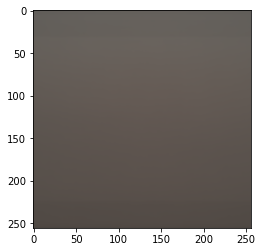

In [27]:
mean_array = rgb_mean(image_shape, dataset)
plt.imshow(mean_array / 255.0)

#### Construct & Pre-process batch data

In [28]:
def sample_data(data, coco, rgb_mean):
    
    img_batch = np.random.choice(data, size=batch_size)
    
    ds_low = []
    ds_high = []
    
    for i, index in enumerate(img_batch):
        input_image = load(index)
        x_image = reformat(input_image)
        n_image = normalize(x_image)

        if coco:
            n_image = augment(n_image)
        
        if rgb_mean:
            n_image -= normalize(mean_array)

        low_resolution_image, high_resolution_image = resize(n_image)

        ds_low.append(low_resolution_image)
        ds_high.append(high_resolution_image)

    ds_low = tf.convert_to_tensor(ds_low)        
    ds_high = tf.convert_to_tensor(ds_high)

    return ds_low, ds_high

#### Review batches for training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train_ds_low.shape = (16, 64, 64, 3)
train_ds_high.shape = (16, 256, 256, 3)
test_ds_low.shape = (16, 64, 64, 3)
test_ds_high.shape = (16, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


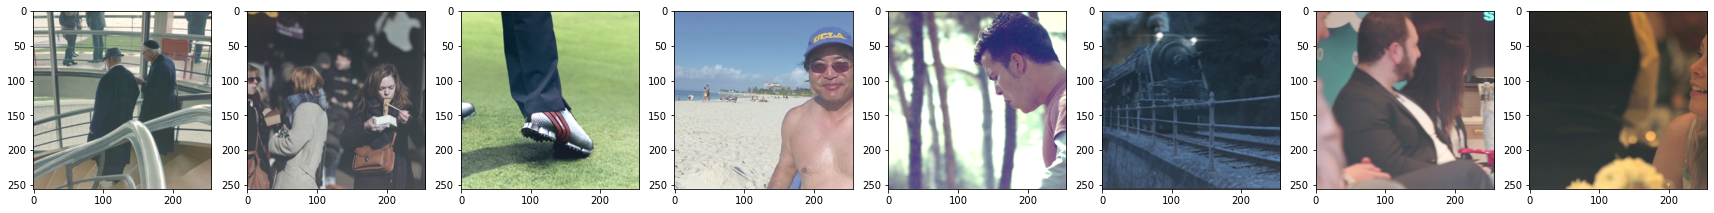

In [29]:
train_ds_low, train_ds_high = sample_data(n_train_imgs, coco=True, rgb_mean=True)
print("train_ds_low.shape = {}".format(train_ds_low.shape))
print("train_ds_high.shape = {}".format(train_ds_high.shape))

test_ds_low, test_ds_high = sample_data(n_test_imgs, coco=False, rgb_mean=False)
print("test_ds_low.shape = {}".format(test_ds_low.shape))
print("test_ds_high.shape = {}".format(test_ds_high.shape))

fig = plt.figure(figsize=(30,30))
for count in range(0,batch_size//2):
    image = train_ds_high[count]
    ax = fig.add_subplot(1,batch_size//2,count+1)
    ax.imshow(image * 0.5 + 0.5)

## Training the network

In [30]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=False)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

#### Loss functions

In [31]:
mean_squared_error = tf.keras.losses.MeanAbsoluteError()
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [32]:
schedule = PiecewiseConstantDecay(boundaries=[200000], values=[1e-4, 5e-5])
generator_optimizer = Adam(learning_rate=schedule)
discriminator_optimizer = Adam(learning_rate=schedule)

In [33]:
def generator_loss(sr_out):
    return binary_cross_entropy(tf.ones_like(sr_out), sr_out)

In [34]:
def discriminator_loss(hr_out, sr_out):
    hr_loss = binary_cross_entropy(tf.ones_like(hr_out), hr_out)
    sr_loss = binary_cross_entropy(tf.zeros_like(sr_out), sr_out)
    return hr_loss + sr_loss

In [35]:
@tf.function
def content_loss(hr, sr):
    sr = tf.keras.applications.vgg19.preprocess_input(sr)
    hr = tf.keras.applications.vgg19.preprocess_input(hr)
    sr_features = vgg(sr) / 12.75
    hr_features = vgg(hr) / 12.75
    return mean_squared_error(hr_features, sr_features)

In [36]:
@tf.function
def train_step(lr, hr):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:   
        # Forward pass
        sr = generator(lr, training=True)
        hr_output = discriminator(hr, training=True)
        sr_output = discriminator(sr, training=True)

        # Compute losses
        con_loss = content_loss(hr, sr)
        gen_loss = generator_loss(sr_output)
        perc_loss = con_loss + 0.001 * gen_loss
        disc_loss = discriminator_loss(hr_output, sr_output)

    # Compute gradients
    generator_gradients = gen_tape.gradient(perc_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Update weights
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    
    return con_loss, gen_loss, perc_loss, disc_loss

#### Checkpoints

In [37]:
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
print("ID:", timestamp)

ID: 20210709-224514


In [38]:
log_dir = OUTDIR + "/logs"
summary_writer = tf.summary.create_file_writer(log_dir + "/fit/" + timestamp)

In [39]:
checkpoint_dir = OUTDIR + '/training_checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#### Restore checkpoint (Optional)

In [40]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

#### Training loop

In [41]:
command = "tensorboard --logdir=" + str(log_dir) + " --port=6006 &"
os.system(command)

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [42]:
EPOCHS = 100                          # Train final to 300000
loss_min = 9999999

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


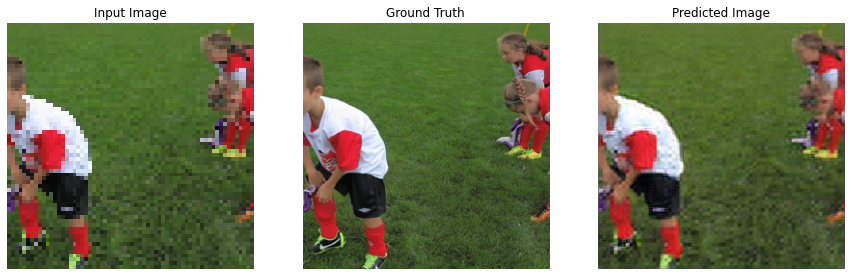

Epoch:  99
................

In [43]:
for epoch in range(EPOCHS):

    clear_output(wait=True)
    
    test_ds_low, test_ds_high = sample_data(n_test_imgs, coco=False, rgb_mean=False)
    train_ds_low, train_ds_high = sample_data(n_train_imgs, coco=True, rgb_mean=True)

    generate_images(generator, test_ds_low, test_ds_high)
    
    print("Epoch: ", epoch)
    
    # Train
    for i in range(batch_size):
        print('.', end='')
        if (i+1) % 100 == 0:
            print()
        
        lr = tf.expand_dims(train_ds_low[i], axis=0)
        hr = tf.expand_dims(train_ds_high[i], axis=0)
        
        con_loss, gen_loss, perc_loss, disc_loss = train_step(lr, hr)
        
        with summary_writer.as_default():
            tf.summary.scalar('con_loss', con_loss, step=epoch)
            tf.summary.scalar('gen_loss', gen_loss, step=epoch)
            tf.summary.scalar('perc_loss', perc_loss, step=epoch)
            tf.summary.scalar('disc_loss', disc_loss, step=epoch)

    if perc_loss < loss_min:
        generator.save(OUTDIR + "/results/edsr_generator_" + timestamp + '.h5')
        print(" Model saved")
        loss_min = perc_loss

    if (epoch + 1) % 10000 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

## Inference

In [44]:
generator = build_edsr(r, num_filters, depth)
generator.load_weights(OUTDIR + "/results/edsr_generator_" + timestamp + ".h5")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


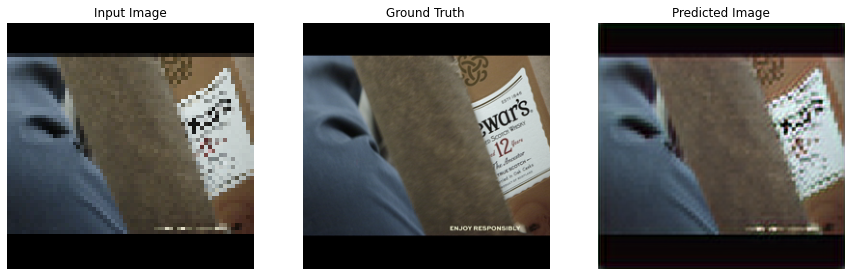

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


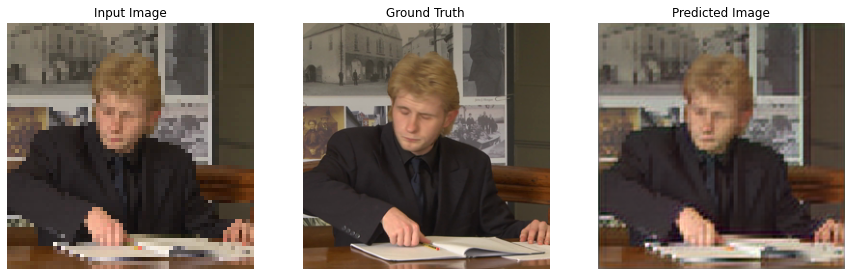

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


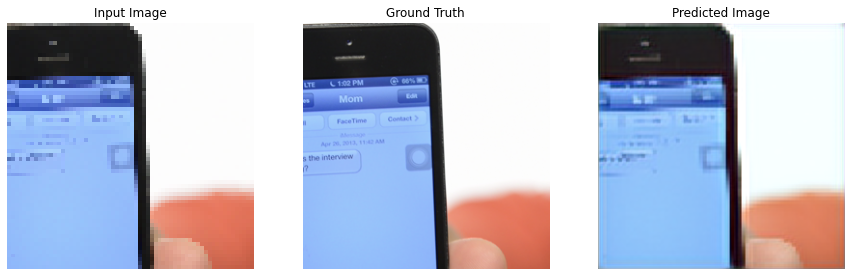

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


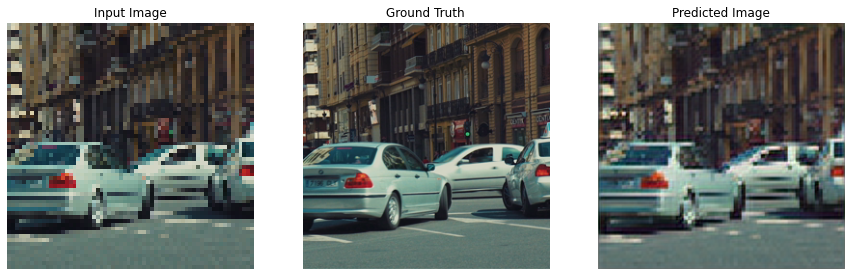

In [45]:
for i in range(batch_size//4):
    val_ds_low, val_ds_high = sample_data(n_val_imgs, coco=False, rgb_mean=False)
    generate_images(generator, val_ds_low, val_ds_high)

## Validation

In [46]:
def evaluate_psnr(model, ds_low, ds_high):
    psnr_values = []
    for i in range(batch_size):
        
        lr = tf.expand_dims(val_ds_low[i], axis=0)
        hr = tf.expand_dims(val_ds_high[i], axis=0)
        
        prediction = model(lr, training=False)
        psnr_value = tf.image.psnr(prediction, hr, max_val = 255.0)
        psnr_values.append(psnr_value)
        
    tf.print(tf.reduce_mean(psnr_values))

In [47]:
val_ds_low, val_ds_high = sample_data(n_val_imgs, coco=False, rgb_mean=False)

In [48]:
print('PSNR: ', end=''), evaluate_psnr(generator, val_ds_low, val_ds_high)

PSNR: 66.5127716


(None, None)